# Setup

In [96]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Tuple
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [97]:
# switch model here: BERT, DeBERTa, RoBERTa, MPNet
model_name = "MPNet"
# switch between balanced and full dataset
balanced = True
run_ID = 10 # 2 epochs

Time formatting function

In [98]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Set random seed values for reproducibility

In [99]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Introduce GPU

In [100]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Read the data

In [101]:
train = pd.read_json('C:/Users/MZywi/Documents/Uni/MSc2/msp/adept/train-dev-test-split/train.json')
dev = pd.read_json('C:/Users/MZywi/Documents/Uni/MSc2/msp/adept/train-dev-test-split/val.json')
test = pd.read_json('C:/Users/MZywi/Documents/Uni/MSc2/msp/adept/train-dev-test-split/test.json')

train['set'] = 'train'
dev['set'] = 'dev'
test['set'] = 'test'
df = pd.concat([train, dev, test])

In [102]:
df.head()

,sentence1,sentence2,modifier,noun,label,idx,set
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,3,13484,train
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,2,2620,train
2,A scene is painted.,A negative scene is painted.,negative,scene,2,3324,train
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,2,10610,train
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,2,14917,train


In [103]:
df['set'].value_counts()

set
train    12892
test      1612
dev       1611
Name: count, dtype: int64

Only keep label classes 1, 2 and 3 (comparison labels). Map them to 0, 1 and 2 for training convenience:

* 1 => 0
* 2 => 1
* 3 => 2

In [104]:
df = df[df['label'].isin([1, 2, 3])]
df['label'].value_counts()

label
2    10805
1     1868
3     1132
Name: count, dtype: int64

In [105]:
df['label'] -= 1
df['label'].value_counts()

label
1    10805
0     1868
2     1132
Name: count, dtype: int64

Filter out duplicated data points

In [106]:
df = df.drop_duplicates(subset=['sentence2'], keep='first')
df['label'].value_counts()

label
1    10800
0     1866
2     1129
Name: count, dtype: int64

Balance the training data by randomly sampling 1500 examples from class 1

In [107]:
train = df[df['set'] == 'train']
dev = df[df['set'] == 'dev']
test = df[df['set'] == 'test']

In [108]:
train['label'].value_counts()

label
1    8631
0    1503
2     926
Name: count, dtype: int64

In [109]:
if balanced:
    train = pd.concat([
        train[train['label'].isin([0, 2])],
        train[train['label'] == 1].sample(1500, random_state=seed_val)
    ])
train['label'].value_counts()

label
0    1503
1    1500
2     926
Name: count, dtype: int64

In [110]:
train.shape

(3929, 7)

Save the data frame to make the results reproducible

In [111]:
#train.to_csv(f'{mount}/datasets/adept/train_comparison_balanced.csv', index=False)

In [112]:
#train = pd.read_csv(f'{mount}/datasets/adept/train_comparison_balanced.csv')
#train.head()

In [113]:
df = pd.concat([train, dev, test])
df.reset_index(inplace=True, drop=True)
df.shape

(6664, 7)

# Tokenization

Our text input for the model will be sentence1 and sentence2 concatenated. Let's generate that input

In [114]:
df['sent_concat'] = df.apply(lambda row: row['sentence1'] + ' ' + row['sentence2'], axis=1)

Load tokenizer

In [115]:
match model_name:
    case "BERT":
        from transformers import BertTokenizer
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    case "DeBERTa":
        from transformers import DebertaTokenizer
        tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    case "RoBERTa":
        from transformers import RobertaTokenizer
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    case "MPNet":
        from transformers import MPNetTokenizer
        tokenizer = MPNetTokenizer.from_pretrained("microsoft/mpnet-base")
    case _:
        from transformers import BertTokenizer
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Now let's calculate max input document length in tokens

In [116]:
max_len = 0
for doc in df['sent_concat']:
    input_ids = tokenizer.encode(doc, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
max_len

46

Our input to the BERT model will be formatted as follows:
> `[CLS] sentence1 [SEP] sentence2 [SEP] `

Seeing that the maximum document length is 46 tokens, we will set the max length hyperparameter to 64



Tokenization function

In [117]:
def tokenize(input_text: list[str]) -> Tuple[torch.Tensor, torch.Tensor]:
  input_ids = []
  attention_masks = []

  for doc in tqdm(input_text):
      encoded_dict = tokenizer.encode_plus(
                          doc,                       # Document to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          return_attention_mask = True,   # Construct attention masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  return input_ids, attention_masks

Apply the tokenization function to the data

In [118]:
# train
train_docs = df[df['set'] == 'train']['sent_concat'].to_list()
train_input_ids, train_attention_masks = tokenize(train_docs)

# validation (dev)
dev_docs = df[df['set'] == 'dev']['sent_concat'].to_list()
dev_input_ids, dev_attention_masks = tokenize(dev_docs)

# test
test_docs = df[df['set'] == 'test']['sent_concat'].to_list()
test_input_ids, test_attention_masks = tokenize(test_docs)

100%|██████████| 1380/1380 [00:00<00:00, 2144.95it/s]


Create a `torch` dataset and dataloader to conveniently load it into the model

In [119]:
# train
train_labels = torch.tensor(df[df['set'] == 'train']['label'].to_list())
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# validation (dev)
dev_labels = torch.tensor(df[df['set'] == 'dev']['label'].to_list())
validation_dataset = TensorDataset(dev_input_ids, dev_attention_masks, dev_labels)

# test
test_labels = torch.tensor(df[df['set'] == 'test']['label'].to_list())
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [120]:
batch_size = 16

# train
train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),  # Select batches randomly
            batch_size=batch_size
        )

# validation (dev)
validation_dataloader = DataLoader(
            validation_dataset,
            sampler=SequentialSampler(validation_dataset),  # Pull out batches sequentially
            batch_size=batch_size
        )

# test
test_dataloader = DataLoader(
            test_dataset,
            sampler=SequentialSampler(test_dataset),  # Pull out batches sequentially
            batch_size=batch_size
        )

print(f'train:  {len(train_dataset)} data points, {len(train_dataloader)} batches')
print(f'validation (dev): {len(validation_dataset)} data points, {len(validation_dataloader)} batches')
print(f'test: {len(test_dataset)} data points, {len(test_dataloader)} batches')

train:  3929 data points, 246 batches
validation (dev): 1355 data points, 85 batches
test: 1380 data points, 87 batches


# Model

In [121]:
match model_name:
    case "BERT":
        from transformers import BertForSequenceClassification
    case "DeBERTa":
        from transformers import DebertaForSequenceClassification
    case "RoBERTa":
        from transformers import RobertaForSequenceClassification
    case "MPNet":
        from transformers import MPNetForSequenceClassification
    case _:
        from transformers import BertForSequenceClassification

from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [122]:
match model_name:
    case "BERT":
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
    case "DeBERTa":
        model = DebertaForSequenceClassification.from_pretrained(
            "microsoft/deberta-base",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
    case "RoBERTa":
        model = RobertaForSequenceClassification.from_pretrained(
            "roberta-base",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
    case "MPNet":
        model = MPNetForSequenceClassification.from_pretrained(
            "microsoft/mpnet-base",
            #problem_type="multi_label_classification",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
    case _:
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
model.cuda()

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MPNetForSequenceClassification(
  (mpnet): MPNetModel(
    (embeddings): MPNetEmbeddings(
      (word_embeddings): Embedding(30527, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): MPNetEncoder(
      (layer): ModuleList(
        (0-11): 12 x MPNetLayer(
          (attention): MPNetAttention(
            (attn): MPNetSelfAttention(
              (q): Linear(in_features=768, out_features=768, bias=True)
              (k): Linear(in_features=768, out_features=768, bias=True)
              (v): Linear(in_features=768, out_features=768, bias=True)
              (o): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [123]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8  # default
                )

logsoftmax = torch.nn.LogSoftmax(dim=1)  #dim=1
criterion = torch.nn.NLLLoss()

In [124]:
epochs = 2  # changed from 5

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [125]:
from sklearn.metrics import f1_score

def flat_f1_score(y_true, y_pred, average='macro'):
  y_pred = np.argmax(y_pred, axis=1).flatten()
  return f1_score(y_true, y_pred, average=average)

# Training

## Training loop

In [126]:
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    # training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # if step % 40 == 0 and not step == 0:  # progress update
        #     elapsed = format_time(time.time() - t0)
        #     print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        if model_name == "MPNet":
            output = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
        else:
            output = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
        loss, logits = output.loss, output.logits
        loss = criterion(logsoftmax(logits), b_labels)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        del batch
        # break  # 1 batch run for sanity checks

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # validation
    print("")
    print("Validation...")

    t0 = time.time()
    model.eval()
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            if model_name == "MPNet":
                output = model(b_input_ids,
                                attention_mask=b_input_mask,
                               labels=b_labels)
            else:
                output = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss, logits = output.loss, output.logits
        loss = criterion(logsoftmax(logits), b_labels)
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1).flatten()
        b_labels = b_labels.to('cpu').numpy()

        total_eval_f1 += f1_score(b_labels, predictions, average='macro')
        del batch
        # break  # 1 batch run for sanity checks

    # Report the final accuracy for this validation run.
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print("  Macro F1: {0:.2f}".format(avg_val_f1))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Macro F1.': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.97
  Training epoch took: 0:07:51

Validation...
  Macro F1: 0.40
  Validation Loss: 0.94
  Validation took: 0:00:44

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.82
  Training epoch took: 0:07:48

Validation...
  Macro F1: 0.47
  Validation Loss: 0.86
  Validation took: 0:00:44

Training complete!
Total training took 0:17:06 (h:mm:ss)


## Training stats

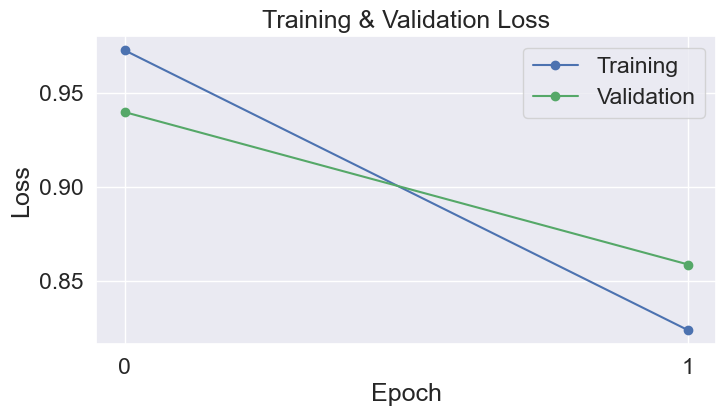

In [127]:
training_stats = pd.DataFrame(data=training_stats)

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,4)

plt.plot(training_stats['Training Loss'], 'b-o', label="Training");
plt.plot(training_stats['Valid. Loss'], 'g-o', label="Validation");

plt.title("Training & Validation Loss");
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.legend();
plt.xticks(range(epochs));

plt.show()

# Validation

Run validation to compare performance to the one reported in the Adept paper

In [130]:
dev_set_predictions = []

for batch in tqdm(validation_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            if model_name == "MPNet":
                output = model(b_input_ids,
                                attention_mask=b_input_mask,
                                labels=b_labels)
            else:
                output = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss, logits = output.loss, output.logits
        loss = criterion(logsoftmax(logits), b_labels)
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1).flatten()
        dev_set_predictions.append(predictions)

        del batch

test_set_predictions = []
for batch in tqdm(test_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            if model_name == "MPNet":
                output = model(b_input_ids,
                                attention_mask=b_input_mask,
                                labels=b_labels)
            else:
                output = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss, logits = output.loss, output.logits
        loss = criterion(logsoftmax(logits), b_labels)
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1).flatten()
        test_set_predictions.append(predictions)

        del batch

100%|██████████| 87/87 [00:44<00:00,  1.97it/s]


Confusion matrix

In [131]:
from sklearn.metrics import confusion_matrix

In [132]:
dev_set_predictions = np.concatenate(dev_set_predictions, axis=0)
dev_conf_matr = confusion_matrix(df[df['set'] == 'dev']['label'].to_list(), dev_set_predictions,
                                 normalize='all')
dev_conf_matr = pd.DataFrame(dev_conf_matr, columns=['Less likely', 'Equally likely', 'More likely'],
                             index=['Less likely', 'Equally likely', 'More likely'])

In [133]:
test_set_predictions = np.concatenate(test_set_predictions, axis=0)
test_conf_matr = confusion_matrix(df[df['set'] == 'test']['label'].to_list(), test_set_predictions,
                                 normalize='all')
test_conf_matr = pd.DataFrame(test_conf_matr, columns=['Less likely', 'Equally likely', 'More likely'],
                             index=['Less likely', 'Equally likely', 'More likely'])

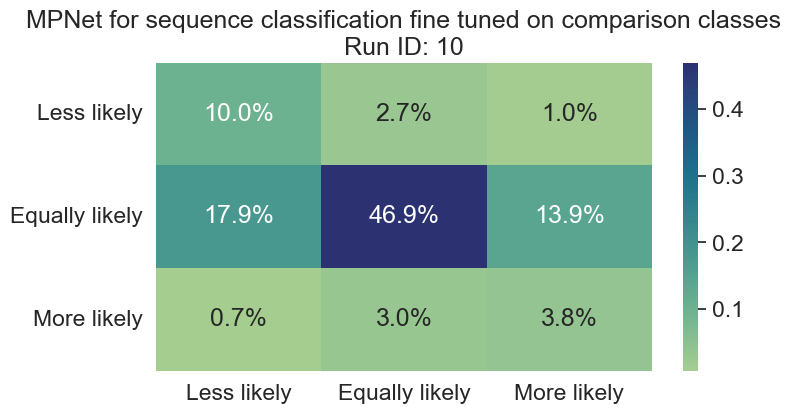

In [134]:
sns.heatmap(dev_conf_matr, cmap='crest', annot=True, fmt=".1%");
plt.title(f'{model_name} for sequence classification fine tuned on comparison classes\nRun ID: {run_ID}');

Weighted F1

In [135]:
print(f1_score(df[df['set'] == 'dev']['label'].to_list(), dev_set_predictions, average='weighted'))

0.6492575824195468


Save the model for later use

In [136]:
filename = model_name + "_" + str(run_ID) + "_" #+ "ep" +str(epochs) + "_"
if len(train[train['label'] == 1]) == 1500:
    filename += "balanced"
else: 
    filename += "full"
filename += ".pt"
print(filename)
torch.save(model, filename)

MPNet_10_balanced.pt
